# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.740924 -1.067815  0.0  0.216868 -0.250907 -0.630085  0  2   4.216010   
1  0.930043 -1.163511  0.0  0.350397 -1.923826 -0.315934  2  0   1.384438   
2 -1.296828 -2.304070  0.0  0.125464 -0.762852  0.634414  3  2   8.202324   
3 -0.069291 -0.248413  0.0  0.246768  1.717296  0.187668  0  0  10.708037   
4 -3.079186 -0.968468  0.0  0.841952  1.742248  0.904504  3  1  29.544752   

            y  
0   16.676570  
1    6.048494  
2  -25.074114  
3  102.046396  
4 -155.448344  
True causal estimate is 5.871500471496929


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

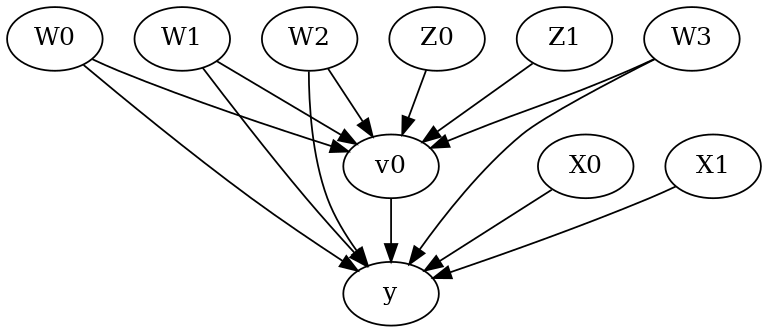

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 5.871711012799331



## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 14.093399804197134
Effect estimates: [[17.32764608]
 [13.10110859]
 [11.75291298]
 [12.94755289]
 [12.2846184 ]
 [17.54836756]
 [11.11702647]
 [18.41016751]
 [19.23759601]
 [19.76114089]
 [15.06141097]
 [18.8235316 ]
 [15.44559929]
 [10.48376486]
 [15.46002543]
 [17.39521103]
 [17.49903201]
 [15.47020753]
 [13.93644908]
 [13.92183876]
 [10.84343414]
 [ 8.36893774]
 [12.07295922]
 [ 8.35609312]
 [12.38650584]
 [13.58462286]
 [14.02489884]
 [11.20695484]
 [ 7.99278314]
 [13.88801569]
 [23.75098931]
 [21.47532937]
 [10.10024329]
 [15.452

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 5.871500471496929


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X0,X1
Target units: 

## Estimate
Mean value: 5.87928828385632
Effect estimates: [[ 2.96621191]
 [ 9.27123469]
 [-4.03561751]
 ...
 [ 1.38442848]
 [-3.25622819]
 [10.74256599]]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X0,X1
Target units: ate

## Estimate
Mean value: 5.895855857106508
Effect estimates: [[ 2.96688558]
 [ 9.21596277]
 [-4.046332  ]
 ...
 [ 1.48359127]
 [-3.23716227]
 [10.72525122]]
95.0% confidence interval: [[[ 2.88739577  9.21758429 -4.48874422 ...  1.28799396 -3.61228521
   10.87975308]]

 [[ 3.0493602   9.58913241 -4.13003551 ...  1.66733723 -3.29376891
   11.12307153]]]



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[14.24395319]
 [13.88179568]
 [12.63417269]
 [11.47380347]
 [16.94232403]
 [15.38672902]
 [13.88681676]
 [14.23630958]
 [13.85371213]
 [14.15434791]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.311994 -0.505457  0.0  0.160226 -0.361465  2.006256 -1.236615   
1    -1.315659 -1.302639  1.0  0.155737 -0.827077 -0.344555 -2.331350   
2    -2.084431 -0.829486  0.0  0.802196 -0.541953 -0.817809 -0.817120   
3    -2.253922 -1.358125  0.0  0.682250 -1.259298  1.229375 -2.880506   
4    -0.516673 -0.276683  0.0  0.650194 -0.822386  0.524913  0.328398   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -1.548197 -0.609547  0.0  0.843484 -0.689754  1.171619 -1.166895   
9996 -0.596750 -0.868158  0.0  0.500547  0.516372 -1.072577  0.445192   
9997  0.381802 -1.952065  0.0  0.408880 -1.431193  0.949150 -1.420653   
9998  0.239955  0.116246  0.0  0.178637 -1.018339  1.297425 -2.068809   
9999  0.813194 -2.763331  0.0  0.947739 -1.464540  0.107469  0.144464   

            W3  v0  y  
0     0.340700   1  1  
1    -1.579667   0  0  
2    -0.170524   1  1  
3     0.160862   0  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X0,X1
Target units: ate

## Estimate
Mean value: 0.5617976330449431
Effect estimates: [[0.56945981]
 [0.53936041]
 [0.54947986]
 ...
 [0.5291169 ]
 [0.59162353]
 [0.50673252]]

True causal estimate is 0.5202


### Instrumental Variable Method

In [16]:
import keras
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.iv.nnet.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2023-04-03 14:14:37.536669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 14:14:37.673795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 14:14:37.673828: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-04-03 14:14:38.403613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-03 14:14:38.403740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-03 14:14:38.403750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2023-04-03 14:14:39.192211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-03 14:14:39.192242: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-03 14:14:39.192265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0bd94ce223e4): /proc/driver/nvidia/version does not exist
2023-04-03 14:14:39.192745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 5:26 - loss: 105.8330

 34/313 [==>...........................] - ETA: 0s - loss: 23.7414   

 69/313 [=====>........................] - ETA: 0s - loss: 14.1734

103/313 [========>.....................] - ETA: 0s - loss: 11.0118

138/313 [============>.................] - ETA: 0s - loss: 9.3133 

173/313 [===============>..............] - ETA: 0s - loss: 8.2741

203/313 [==================>...........] - ETA: 0s - loss: 7.6494

239/313 [=====================>........] - ETA: 0s - loss: 7.0960

275/313 [=========================>....] - ETA: 0s - loss: 6.6814

310/313 [============================>.] - ETA: 0s - loss: 6.3555

313/313 [==============================] - 2s 1ms/step - loss: 6.3308


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 3.9639

 36/313 [==>...........................] - ETA: 0s - loss: 3.7895

 71/313 [=====>........................] - ETA: 0s - loss: 3.7120

105/313 [=========>....................] - ETA: 0s - loss: 3.6829

140/313 [============>.................] - ETA: 0s - loss: 3.6504

175/313 [===============>..............] - ETA: 0s - loss: 3.6189

210/313 [===================>..........] - ETA: 0s - loss: 3.5613

246/313 [======================>.......] - ETA: 0s - loss: 3.5087

282/313 [==========================>...] - ETA: 0s - loss: 3.4512

313/313 [==============================] - 0s 1ms/step - loss: 3.3998


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 2.7698

 36/313 [==>...........................] - ETA: 0s - loss: 2.8483

 71/313 [=====>........................] - ETA: 0s - loss: 2.8342

106/313 [=========>....................] - ETA: 0s - loss: 2.8340

141/313 [============>.................] - ETA: 0s - loss: 2.8260

176/313 [===============>..............] - ETA: 0s - loss: 2.8112

211/313 [===================>..........] - ETA: 0s - loss: 2.7993

246/313 [======================>.......] - ETA: 0s - loss: 2.7894

279/313 [=========================>....] - ETA: 0s - loss: 2.7776

313/313 [==============================] - 0s 1ms/step - loss: 2.7693


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 2.7362

 36/313 [==>...........................] - ETA: 0s - loss: 2.6963

 71/313 [=====>........................] - ETA: 0s - loss: 2.6791

105/313 [=========>....................] - ETA: 0s - loss: 2.6705

140/313 [============>.................] - ETA: 0s - loss: 2.6641

175/313 [===============>..............] - ETA: 0s - loss: 2.6697

209/313 [===================>..........] - ETA: 0s - loss: 2.6715

244/313 [======================>.......] - ETA: 0s - loss: 2.6719

279/313 [=========================>....] - ETA: 0s - loss: 2.6622

313/313 [==============================] - 0s 1ms/step - loss: 2.6577


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 2.3395

 36/313 [==>...........................] - ETA: 0s - loss: 2.6254

 71/313 [=====>........................] - ETA: 0s - loss: 2.6050

106/313 [=========>....................] - ETA: 0s - loss: 2.6125

142/313 [============>.................] - ETA: 0s - loss: 2.6101

178/313 [================>.............] - ETA: 0s - loss: 2.6110

214/313 [===================>..........] - ETA: 0s - loss: 2.6065

247/313 [======================>.......] - ETA: 0s - loss: 2.6037

283/313 [==========================>...] - ETA: 0s - loss: 2.6006

313/313 [==============================] - 0s 1ms/step - loss: 2.5943


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 2.7349

 37/313 [==>...........................] - ETA: 0s - loss: 2.6033

 73/313 [=====>........................] - ETA: 0s - loss: 2.6083

108/313 [=========>....................] - ETA: 0s - loss: 2.5864

143/313 [============>.................] - ETA: 0s - loss: 2.5808

178/313 [================>.............] - ETA: 0s - loss: 2.5785

210/313 [===================>..........] - ETA: 0s - loss: 2.5743

242/313 [======================>.......] - ETA: 0s - loss: 2.5679

277/313 [=========================>....] - ETA: 0s - loss: 2.5649

313/313 [==============================] - ETA: 0s - loss: 2.5646

313/313 [==============================] - 0s 1ms/step - loss: 2.5646


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 2.5517

 37/313 [==>...........................] - ETA: 0s - loss: 2.5819

 73/313 [=====>........................] - ETA: 0s - loss: 2.5611

108/313 [=========>....................] - ETA: 0s - loss: 2.5520

143/313 [============>.................] - ETA: 0s - loss: 2.5451

177/313 [===============>..............] - ETA: 0s - loss: 2.5457

212/313 [===================>..........] - ETA: 0s - loss: 2.5398

248/313 [======================>.......] - ETA: 0s - loss: 2.5410

284/313 [==========================>...] - ETA: 0s - loss: 2.5360

313/313 [==============================] - 0s 1ms/step - loss: 2.5344


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 2.6107

 37/313 [==>...........................] - ETA: 0s - loss: 2.5055

 70/313 [=====>........................] - ETA: 0s - loss: 2.4922

101/313 [========>.....................] - ETA: 0s - loss: 2.4813

135/313 [===========>..................] - ETA: 0s - loss: 2.4975

168/313 [===============>..............] - ETA: 0s - loss: 2.5092

199/313 [==================>...........] - ETA: 0s - loss: 2.5132

235/313 [=====================>........] - ETA: 0s - loss: 2.5113

270/313 [========================>.....] - ETA: 0s - loss: 2.5129

301/313 [===========================>..] - ETA: 0s - loss: 2.5102

313/313 [==============================] - 0s 2ms/step - loss: 2.5059


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 2.3711

 37/313 [==>...........................] - ETA: 0s - loss: 2.4942

 69/313 [=====>........................] - ETA: 0s - loss: 2.4941

104/313 [========>.....................] - ETA: 0s - loss: 2.4928

139/313 [============>.................] - ETA: 0s - loss: 2.4939

174/313 [===============>..............] - ETA: 0s - loss: 2.4922

205/313 [==================>...........] - ETA: 0s - loss: 2.4885

237/313 [=====================>........] - ETA: 0s - loss: 2.4943

272/313 [=========================>....] - ETA: 0s - loss: 2.4970

307/313 [============================>.] - ETA: 0s - loss: 2.4951

313/313 [==============================] - 0s 2ms/step - loss: 2.4935


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2.4544

 36/313 [==>...........................] - ETA: 0s - loss: 2.5132

 71/313 [=====>........................] - ETA: 0s - loss: 2.4910

106/313 [=========>....................] - ETA: 0s - loss: 2.4992

141/313 [============>.................] - ETA: 0s - loss: 2.4907

176/313 [===============>..............] - ETA: 0s - loss: 2.4904

210/313 [===================>..........] - ETA: 0s - loss: 2.4895

244/313 [======================>.......] - ETA: 0s - loss: 2.4871

278/313 [=========================>....] - ETA: 0s - loss: 2.4878

312/313 [============================>.] - ETA: 0s - loss: 2.4823

313/313 [==============================] - 0s 1ms/step - loss: 2.4825


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 2.2506

 35/313 [==>...........................] - ETA: 0s - loss: 2.4790

 70/313 [=====>........................] - ETA: 0s - loss: 2.4738

102/313 [========>.....................] - ETA: 0s - loss: 2.4713

132/313 [===========>..................] - ETA: 0s - loss: 2.4806

167/313 [===============>..............] - ETA: 0s - loss: 2.4744

201/313 [==================>...........] - ETA: 0s - loss: 2.4732

235/313 [=====================>........] - ETA: 0s - loss: 2.4713

270/313 [========================>.....] - ETA: 0s - loss: 2.4702

305/313 [============================>.] - ETA: 0s - loss: 2.4721

313/313 [==============================] - 0s 1ms/step - loss: 2.4722


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 2.3169

 34/313 [==>...........................] - ETA: 0s - loss: 2.4724

 69/313 [=====>........................] - ETA: 0s - loss: 2.4722

104/313 [========>.....................] - ETA: 0s - loss: 2.4736

139/313 [============>.................] - ETA: 0s - loss: 2.4629

173/313 [===============>..............] - ETA: 0s - loss: 2.4684

208/313 [==================>...........] - ETA: 0s - loss: 2.4723

239/313 [=====================>........] - ETA: 0s - loss: 2.4662

271/313 [========================>.....] - ETA: 0s - loss: 2.4673

307/313 [============================>.] - ETA: 0s - loss: 2.4663

313/313 [==============================] - 0s 2ms/step - loss: 2.4655


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 2.5646

 36/313 [==>...........................] - ETA: 0s - loss: 2.4701

 71/313 [=====>........................] - ETA: 0s - loss: 2.4680

106/313 [=========>....................] - ETA: 0s - loss: 2.4587

140/313 [============>.................] - ETA: 0s - loss: 2.4646

173/313 [===============>..............] - ETA: 0s - loss: 2.4627

207/313 [==================>...........] - ETA: 0s - loss: 2.4634

242/313 [======================>.......] - ETA: 0s - loss: 2.4584

277/313 [=========================>....] - ETA: 0s - loss: 2.4630

311/313 [============================>.] - ETA: 0s - loss: 2.4662

313/313 [==============================] - 0s 1ms/step - loss: 2.4672


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 2.2907

 31/313 [=>............................] - ETA: 0s - loss: 2.4722

 66/313 [=====>........................] - ETA: 0s - loss: 2.4528

101/313 [========>.....................] - ETA: 0s - loss: 2.4589

135/313 [===========>..................] - ETA: 0s - loss: 2.4485

169/313 [===============>..............] - ETA: 0s - loss: 2.4510

203/313 [==================>...........] - ETA: 0s - loss: 2.4527

237/313 [=====================>........] - ETA: 0s - loss: 2.4492

268/313 [========================>.....] - ETA: 0s - loss: 2.4538

301/313 [===========================>..] - ETA: 0s - loss: 2.4580

313/313 [==============================] - 0s 2ms/step - loss: 2.4584


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 2.4864

 36/313 [==>...........................] - ETA: 0s - loss: 2.4455

 71/313 [=====>........................] - ETA: 0s - loss: 2.4490

105/313 [=========>....................] - ETA: 0s - loss: 2.4420

139/313 [============>.................] - ETA: 0s - loss: 2.4324

174/313 [===============>..............] - ETA: 0s - loss: 2.4316

209/313 [===================>..........] - ETA: 0s - loss: 2.4394

244/313 [======================>.......] - ETA: 0s - loss: 2.4452

279/313 [=========================>....] - ETA: 0s - loss: 2.4469

313/313 [==============================] - ETA: 0s - loss: 2.4471

313/313 [==============================] - 0s 1ms/step - loss: 2.4471


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 2.4861

 35/313 [==>...........................] - ETA: 0s - loss: 2.4654

 69/313 [=====>........................] - ETA: 0s - loss: 2.4571

102/313 [========>.....................] - ETA: 0s - loss: 2.4486

136/313 [============>.................] - ETA: 0s - loss: 2.4515

171/313 [===============>..............] - ETA: 0s - loss: 2.4426

205/313 [==================>...........] - ETA: 0s - loss: 2.4500

235/313 [=====================>........] - ETA: 0s - loss: 2.4474

269/313 [========================>.....] - ETA: 0s - loss: 2.4431

300/313 [===========================>..] - ETA: 0s - loss: 2.4430

313/313 [==============================] - 0s 2ms/step - loss: 2.4440


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 2.3697

 36/313 [==>...........................] - ETA: 0s - loss: 2.4582

 71/313 [=====>........................] - ETA: 0s - loss: 2.4423

106/313 [=========>....................] - ETA: 0s - loss: 2.4465

141/313 [============>.................] - ETA: 0s - loss: 2.4498

175/313 [===============>..............] - ETA: 0s - loss: 2.4436

210/313 [===================>..........] - ETA: 0s - loss: 2.4394

244/313 [======================>.......] - ETA: 0s - loss: 2.4376

279/313 [=========================>....] - ETA: 0s - loss: 2.4374

313/313 [==============================] - ETA: 0s - loss: 2.4359

313/313 [==============================] - 0s 1ms/step - loss: 2.4359


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 2.7386

 36/313 [==>...........................] - ETA: 0s - loss: 2.4753

 71/313 [=====>........................] - ETA: 0s - loss: 2.4555

106/313 [=========>....................] - ETA: 0s - loss: 2.4613

140/313 [============>.................] - ETA: 0s - loss: 2.4612

174/313 [===============>..............] - ETA: 0s - loss: 2.4583

208/313 [==================>...........] - ETA: 0s - loss: 2.4553

241/313 [======================>.......] - ETA: 0s - loss: 2.4503

274/313 [=========================>....] - ETA: 0s - loss: 2.4462

308/313 [============================>.] - ETA: 0s - loss: 2.4456

313/313 [==============================] - 0s 1ms/step - loss: 2.4443


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 2.3596

 35/313 [==>...........................] - ETA: 0s - loss: 2.4454

 70/313 [=====>........................] - ETA: 0s - loss: 2.4341

104/313 [========>.....................] - ETA: 0s - loss: 2.4268

134/313 [===========>..................] - ETA: 0s - loss: 2.4243

168/313 [===============>..............] - ETA: 0s - loss: 2.4350

202/313 [==================>...........] - ETA: 0s - loss: 2.4283

237/313 [=====================>........] - ETA: 0s - loss: 2.4311

269/313 [========================>.....] - ETA: 0s - loss: 2.4352

302/313 [===========================>..] - ETA: 0s - loss: 2.4320

313/313 [==============================] - 0s 2ms/step - loss: 2.4332


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2.5815

 35/313 [==>...........................] - ETA: 0s - loss: 2.4240

 68/313 [=====>........................] - ETA: 0s - loss: 2.4309

103/313 [========>.....................] - ETA: 0s - loss: 2.4342

137/313 [============>.................] - ETA: 0s - loss: 2.4333

168/313 [===============>..............] - ETA: 0s - loss: 2.4345

202/313 [==================>...........] - ETA: 0s - loss: 2.4353

236/313 [=====================>........] - ETA: 0s - loss: 2.4309

267/313 [========================>.....] - ETA: 0s - loss: 2.4340

300/313 [===========================>..] - ETA: 0s - loss: 2.4296

313/313 [==============================] - 0s 2ms/step - loss: 2.4311


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 2.4578

 36/313 [==>...........................] - ETA: 0s - loss: 2.4514

 67/313 [=====>........................] - ETA: 0s - loss: 2.4082

101/313 [========>.....................] - ETA: 0s - loss: 2.4170

136/313 [============>.................] - ETA: 0s - loss: 2.4167

170/313 [===============>..............] - ETA: 0s - loss: 2.4226

204/313 [==================>...........] - ETA: 0s - loss: 2.4201

237/313 [=====================>........] - ETA: 0s - loss: 2.4243

271/313 [========================>.....] - ETA: 0s - loss: 2.4246

304/313 [============================>.] - ETA: 0s - loss: 2.4278

313/313 [==============================] - 0s 2ms/step - loss: 2.4266


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 2.4713

 32/313 [==>...........................] - ETA: 0s - loss: 2.4450

 67/313 [=====>........................] - ETA: 0s - loss: 2.4406

101/313 [========>.....................] - ETA: 0s - loss: 2.4526

136/313 [============>.................] - ETA: 0s - loss: 2.4468

171/313 [===============>..............] - ETA: 0s - loss: 2.4378

201/313 [==================>...........] - ETA: 0s - loss: 2.4412

233/313 [=====================>........] - ETA: 0s - loss: 2.4416

267/313 [========================>.....] - ETA: 0s - loss: 2.4390

302/313 [===========================>..] - ETA: 0s - loss: 2.4337

313/313 [==============================] - 0s 2ms/step - loss: 2.4318


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 2.3115

 36/313 [==>...........................] - ETA: 0s - loss: 2.4106

 71/313 [=====>........................] - ETA: 0s - loss: 2.4117

105/313 [=========>....................] - ETA: 0s - loss: 2.4160

138/313 [============>.................] - ETA: 0s - loss: 2.4160

172/313 [===============>..............] - ETA: 0s - loss: 2.4207

206/313 [==================>...........] - ETA: 0s - loss: 2.4218

240/313 [======================>.......] - ETA: 0s - loss: 2.4198

274/313 [=========================>....] - ETA: 0s - loss: 2.4219

309/313 [============================>.] - ETA: 0s - loss: 2.4250

313/313 [==============================] - 0s 1ms/step - loss: 2.4250


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2.5483

 36/313 [==>...........................] - ETA: 0s - loss: 2.4377

 71/313 [=====>........................] - ETA: 0s - loss: 2.4372

106/313 [=========>....................] - ETA: 0s - loss: 2.4299

140/313 [============>.................] - ETA: 0s - loss: 2.4350

171/313 [===============>..............] - ETA: 0s - loss: 2.4281

204/313 [==================>...........] - ETA: 0s - loss: 2.4274

239/313 [=====================>........] - ETA: 0s - loss: 2.4263

271/313 [========================>.....] - ETA: 0s - loss: 2.4268

305/313 [============================>.] - ETA: 0s - loss: 2.4257

313/313 [==============================] - 0s 2ms/step - loss: 2.4243


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2.5395

 31/313 [=>............................] - ETA: 0s - loss: 2.4418

 65/313 [=====>........................] - ETA: 0s - loss: 2.4381

 98/313 [========>.....................] - ETA: 0s - loss: 2.4199

128/313 [===========>..................] - ETA: 0s - loss: 2.4116

162/313 [==============>...............] - ETA: 0s - loss: 2.4210

197/313 [=================>............] - ETA: 0s - loss: 2.4249

231/313 [=====================>........] - ETA: 0s - loss: 2.4256

263/313 [========================>.....] - ETA: 0s - loss: 2.4236

295/313 [===========================>..] - ETA: 0s - loss: 2.4235

313/313 [==============================] - 0s 2ms/step - loss: 2.4202


Epoch 1/25


  1/313 [..............................] - ETA: 7:46 - loss: 13369.1904

 26/313 [=>............................] - ETA: 0s - loss: 21836.6426  

 53/313 [====>.........................] - ETA: 0s - loss: 19260.1270

 80/313 [======>.......................] - ETA: 0s - loss: 17648.0898

108/313 [=========>....................] - ETA: 0s - loss: 16827.1016

136/313 [============>.................] - ETA: 0s - loss: 15922.2627

164/313 [==============>...............] - ETA: 0s - loss: 15167.9258

189/313 [=================>............] - ETA: 0s - loss: 14803.2920

216/313 [===================>..........] - ETA: 0s - loss: 14201.5947

244/313 [======================>.......] - ETA: 0s - loss: 13730.8662

273/313 [=========================>....] - ETA: 0s - loss: 13033.2578

301/313 [===========================>..] - ETA: 0s - loss: 12509.2422

313/313 [==============================] - 2s 2ms/step - loss: 12289.4062


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 4861.4204

 29/313 [=>............................] - ETA: 0s - loss: 7163.4160

 56/313 [====>.........................] - ETA: 0s - loss: 7061.4854

 84/313 [=======>......................] - ETA: 0s - loss: 6927.0513

112/313 [=========>....................] - ETA: 0s - loss: 6630.2891

141/313 [============>.................] - ETA: 0s - loss: 6559.6162

170/313 [===============>..............] - ETA: 0s - loss: 6610.1719

196/313 [=================>............] - ETA: 0s - loss: 6596.1006

222/313 [====================>.........] - ETA: 0s - loss: 6541.4297

247/313 [======================>.......] - ETA: 0s - loss: 6538.4019

275/313 [=========================>....] - ETA: 0s - loss: 6422.4980

303/313 [============================>.] - ETA: 0s - loss: 6325.0127

313/313 [==============================] - 1s 2ms/step - loss: 6276.6284


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 5614.8667

 29/313 [=>............................] - ETA: 0s - loss: 4672.1802

 57/313 [====>.........................] - ETA: 0s - loss: 5253.0259

 85/313 [=======>......................] - ETA: 0s - loss: 5422.0786

113/313 [=========>....................] - ETA: 0s - loss: 5327.4487

136/313 [============>.................] - ETA: 0s - loss: 5359.8184

162/313 [==============>...............] - ETA: 0s - loss: 5349.4341

190/313 [=================>............] - ETA: 0s - loss: 5361.6113

218/313 [===================>..........] - ETA: 0s - loss: 5382.7710

246/313 [======================>.......] - ETA: 0s - loss: 5376.9160

274/313 [=========================>....] - ETA: 0s - loss: 5374.8228

302/313 [===========================>..] - ETA: 0s - loss: 5413.3921

313/313 [==============================] - 1s 2ms/step - loss: 5383.9668


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 3257.8108

 29/313 [=>............................] - ETA: 0s - loss: 5937.6318

 57/313 [====>.........................] - ETA: 0s - loss: 5990.6597

 85/313 [=======>......................] - ETA: 0s - loss: 5534.1138

113/313 [=========>....................] - ETA: 0s - loss: 5544.1675

141/313 [============>.................] - ETA: 0s - loss: 5528.5718

169/313 [===============>..............] - ETA: 0s - loss: 5387.7407

197/313 [=================>............] - ETA: 0s - loss: 5440.4048

225/313 [====================>.........] - ETA: 0s - loss: 5420.8501

253/313 [=======================>......] - ETA: 0s - loss: 5370.3374

281/313 [=========================>....] - ETA: 0s - loss: 5350.5723

309/313 [============================>.] - ETA: 0s - loss: 5319.5405

313/313 [==============================] - 1s 2ms/step - loss: 5300.3257


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 7860.6167

 29/313 [=>............................] - ETA: 0s - loss: 4971.3252

 57/313 [====>.........................] - ETA: 0s - loss: 9948.1992

 85/313 [=======>......................] - ETA: 0s - loss: 8997.5342

112/313 [=========>....................] - ETA: 0s - loss: 8262.3809

140/313 [============>.................] - ETA: 0s - loss: 7719.3491

168/313 [===============>..............] - ETA: 0s - loss: 7294.7930

195/313 [=================>............] - ETA: 0s - loss: 7064.6841

223/313 [====================>.........] - ETA: 0s - loss: 6993.7070

251/313 [=======================>......] - ETA: 0s - loss: 6917.5781

279/313 [=========================>....] - ETA: 0s - loss: 6701.3184

307/313 [============================>.] - ETA: 0s - loss: 6549.3789

313/313 [==============================] - 1s 2ms/step - loss: 6520.4863


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 8874.5732

 29/313 [=>............................] - ETA: 0s - loss: 5547.6924

 57/313 [====>.........................] - ETA: 0s - loss: 5539.6816

 85/313 [=======>......................] - ETA: 0s - loss: 5293.2910

113/313 [=========>....................] - ETA: 0s - loss: 5341.4512

141/313 [============>.................] - ETA: 0s - loss: 5187.6685

169/313 [===============>..............] - ETA: 0s - loss: 5193.6626

196/313 [=================>............] - ETA: 0s - loss: 5287.4756

224/313 [====================>.........] - ETA: 0s - loss: 5302.5005

252/313 [=======================>......] - ETA: 0s - loss: 5291.3784

279/313 [=========================>....] - ETA: 0s - loss: 5333.0522

306/313 [============================>.] - ETA: 0s - loss: 5381.1011

313/313 [==============================] - 1s 2ms/step - loss: 5374.4312


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 4660.3662

 29/313 [=>............................] - ETA: 0s - loss: 5671.0933

 57/313 [====>.........................] - ETA: 0s - loss: 5533.5386

 85/313 [=======>......................] - ETA: 0s - loss: 5498.2065

113/313 [=========>....................] - ETA: 0s - loss: 5937.8350

141/313 [============>.................] - ETA: 0s - loss: 5893.4673

166/313 [==============>...............] - ETA: 0s - loss: 5869.0581

191/313 [=================>............] - ETA: 0s - loss: 5887.9712

218/313 [===================>..........] - ETA: 0s - loss: 5717.7461

246/313 [======================>.......] - ETA: 0s - loss: 5653.2017

275/313 [=========================>....] - ETA: 0s - loss: 5625.6616

304/313 [============================>.] - ETA: 0s - loss: 5557.0278

313/313 [==============================] - 1s 2ms/step - loss: 5543.7280


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 6603.4941

 27/313 [=>............................] - ETA: 0s - loss: 5310.6904

 53/313 [====>.........................] - ETA: 0s - loss: 5072.5137

 80/313 [======>.......................] - ETA: 0s - loss: 4955.7871

106/313 [=========>....................] - ETA: 0s - loss: 5036.3491

135/313 [===========>..................] - ETA: 0s - loss: 5278.0337

163/313 [==============>...............] - ETA: 0s - loss: 5198.8877

191/313 [=================>............] - ETA: 0s - loss: 5136.9390

220/313 [====================>.........] - ETA: 0s - loss: 5116.4971

249/313 [======================>.......] - ETA: 0s - loss: 5083.0967

277/313 [=========================>....] - ETA: 0s - loss: 5132.4814

306/313 [============================>.] - ETA: 0s - loss: 5151.6914

313/313 [==============================] - 1s 2ms/step - loss: 5118.7417


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 6135.2441

 30/313 [=>............................] - ETA: 0s - loss: 5518.5435

 58/313 [====>.........................] - ETA: 0s - loss: 5195.1411

 87/313 [=======>......................] - ETA: 0s - loss: 5169.2456

115/313 [==========>...................] - ETA: 0s - loss: 5345.6816

144/313 [============>.................] - ETA: 0s - loss: 5340.9917

172/313 [===============>..............] - ETA: 0s - loss: 5283.2974

201/313 [==================>...........] - ETA: 0s - loss: 5220.6064

230/313 [=====================>........] - ETA: 0s - loss: 5181.3271

258/313 [=======================>......] - ETA: 0s - loss: 5172.9917

286/313 [==========================>...] - ETA: 0s - loss: 5202.1919

313/313 [==============================] - 1s 2ms/step - loss: 5264.2070


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 4334.2793

 30/313 [=>............................] - ETA: 0s - loss: 5813.8882

 57/313 [====>.........................] - ETA: 0s - loss: 5234.1924

 85/313 [=======>......................] - ETA: 0s - loss: 5352.8462

113/313 [=========>....................] - ETA: 0s - loss: 5256.0781

142/313 [============>.................] - ETA: 0s - loss: 5236.5552

170/313 [===============>..............] - ETA: 0s - loss: 5124.7349

199/313 [==================>...........] - ETA: 0s - loss: 5192.8340

227/313 [====================>.........] - ETA: 0s - loss: 5225.9868

255/313 [=======================>......] - ETA: 0s - loss: 5145.7031

283/313 [==========================>...] - ETA: 0s - loss: 5162.5371

311/313 [============================>.] - ETA: 0s - loss: 5195.9038

313/313 [==============================] - 1s 2ms/step - loss: 5200.8799


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 11635.8398

 29/313 [=>............................] - ETA: 0s - loss: 4799.8550 

 57/313 [====>.........................] - ETA: 0s - loss: 4854.8032

 84/313 [=======>......................] - ETA: 0s - loss: 4969.7656

112/313 [=========>....................] - ETA: 0s - loss: 5157.8374

140/313 [============>.................] - ETA: 0s - loss: 5137.0420

168/313 [===============>..............] - ETA: 0s - loss: 5140.2275

196/313 [=================>............] - ETA: 0s - loss: 5125.1465

224/313 [====================>.........] - ETA: 0s - loss: 5061.8096

252/313 [=======================>......] - ETA: 0s - loss: 5061.7573

280/313 [=========================>....] - ETA: 0s - loss: 5032.1299

308/313 [============================>.] - ETA: 0s - loss: 5024.0244

313/313 [==============================] - 1s 2ms/step - loss: 5057.6587


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 7868.1240

 27/313 [=>............................] - ETA: 0s - loss: 5021.0469

 55/313 [====>.........................] - ETA: 0s - loss: 4932.9180

 83/313 [======>.......................] - ETA: 0s - loss: 5320.8354

111/313 [=========>....................] - ETA: 0s - loss: 5242.2212

139/313 [============>.................] - ETA: 0s - loss: 5194.5400

167/313 [===============>..............] - ETA: 0s - loss: 5282.0923

195/313 [=================>............] - ETA: 0s - loss: 5181.6528

223/313 [====================>.........] - ETA: 0s - loss: 5237.2144

251/313 [=======================>......] - ETA: 0s - loss: 5242.1699

279/313 [=========================>....] - ETA: 0s - loss: 5206.9019

307/313 [============================>.] - ETA: 0s - loss: 5193.3418

313/313 [==============================] - 1s 2ms/step - loss: 5188.4097


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 7477.1069

 29/313 [=>............................] - ETA: 0s - loss: 4851.7104

 57/313 [====>.........................] - ETA: 0s - loss: 5151.3784

 85/313 [=======>......................] - ETA: 0s - loss: 5053.8911

113/313 [=========>....................] - ETA: 0s - loss: 5140.3340

141/313 [============>.................] - ETA: 0s - loss: 5272.8408

169/313 [===============>..............] - ETA: 0s - loss: 5339.6768

197/313 [=================>............] - ETA: 0s - loss: 5386.2061

222/313 [====================>.........] - ETA: 0s - loss: 5278.8979

250/313 [======================>.......] - ETA: 0s - loss: 5211.5005

278/313 [=========================>....] - ETA: 0s - loss: 5211.6128

306/313 [============================>.] - ETA: 0s - loss: 5206.9736

313/313 [==============================] - 1s 2ms/step - loss: 5215.5034


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 5171.9937

 29/313 [=>............................] - ETA: 0s - loss: 6092.5034

 57/313 [====>.........................] - ETA: 0s - loss: 5981.6733

 85/313 [=======>......................] - ETA: 0s - loss: 5632.5054

112/313 [=========>....................] - ETA: 0s - loss: 5753.1514

139/313 [============>.................] - ETA: 0s - loss: 5575.6797

166/313 [==============>...............] - ETA: 0s - loss: 5474.2969

194/313 [=================>............] - ETA: 0s - loss: 5437.0200

222/313 [====================>.........] - ETA: 0s - loss: 5360.6274

250/313 [======================>.......] - ETA: 0s - loss: 5283.7383

278/313 [=========================>....] - ETA: 0s - loss: 5234.4570

306/313 [============================>.] - ETA: 0s - loss: 5219.3857

313/313 [==============================] - 1s 2ms/step - loss: 5176.9653


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 7858.2441

 29/313 [=>............................] - ETA: 0s - loss: 4969.5771

 53/313 [====>.........................] - ETA: 0s - loss: 5182.6299

 82/313 [======>.......................] - ETA: 0s - loss: 4974.2271

110/313 [=========>....................] - ETA: 0s - loss: 4949.9941

139/313 [============>.................] - ETA: 0s - loss: 5054.6426

167/313 [===============>..............] - ETA: 0s - loss: 5101.3242

195/313 [=================>............] - ETA: 0s - loss: 4998.8750

223/313 [====================>.........] - ETA: 0s - loss: 4980.6748

250/313 [======================>.......] - ETA: 0s - loss: 5032.8789

278/313 [=========================>....] - ETA: 0s - loss: 5043.5674

305/313 [============================>.] - ETA: 0s - loss: 5077.0186

313/313 [==============================] - 1s 2ms/step - loss: 5091.3296


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 8195.0391

 29/313 [=>............................] - ETA: 0s - loss: 5472.1104

 57/313 [====>.........................] - ETA: 0s - loss: 5051.2227

 85/313 [=======>......................] - ETA: 0s - loss: 4982.9712

113/313 [=========>....................] - ETA: 0s - loss: 5035.8555

141/313 [============>.................] - ETA: 0s - loss: 4959.9097

169/313 [===============>..............] - ETA: 0s - loss: 5112.4478

196/313 [=================>............] - ETA: 0s - loss: 5128.0278

223/313 [====================>.........] - ETA: 0s - loss: 5075.4512

251/313 [=======================>......] - ETA: 0s - loss: 5083.3364

278/313 [=========================>....] - ETA: 0s - loss: 5111.4658

305/313 [============================>.] - ETA: 0s - loss: 5084.7031

313/313 [==============================] - 1s 2ms/step - loss: 5094.9326


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 5770.2095

 30/313 [=>............................] - ETA: 0s - loss: 4874.9888

 58/313 [====>.........................] - ETA: 0s - loss: 4628.3403

 86/313 [=======>......................] - ETA: 0s - loss: 4550.3760

114/313 [=========>....................] - ETA: 0s - loss: 4606.1172

143/313 [============>.................] - ETA: 0s - loss: 4674.6050

172/313 [===============>..............] - ETA: 0s - loss: 4648.6655

200/313 [==================>...........] - ETA: 0s - loss: 4809.8740

228/313 [====================>.........] - ETA: 0s - loss: 4863.6152

255/313 [=======================>......] - ETA: 0s - loss: 4894.3247

283/313 [==========================>...] - ETA: 0s - loss: 4947.9751

311/313 [============================>.] - ETA: 0s - loss: 4985.0693

313/313 [==============================] - 1s 2ms/step - loss: 4995.1260


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 3109.8594

 26/313 [=>............................] - ETA: 0s - loss: 4978.2290

 51/313 [===>..........................] - ETA: 0s - loss: 4753.2974

 79/313 [======>.......................] - ETA: 0s - loss: 4971.4980

107/313 [=========>....................] - ETA: 0s - loss: 5081.9077

135/313 [===========>..................] - ETA: 0s - loss: 5129.6704

163/313 [==============>...............] - ETA: 0s - loss: 5028.3867

189/313 [=================>............] - ETA: 0s - loss: 5041.9258

217/313 [===================>..........] - ETA: 0s - loss: 5022.5225

246/313 [======================>.......] - ETA: 0s - loss: 5076.8604

275/313 [=========================>....] - ETA: 0s - loss: 5052.8950

303/313 [============================>.] - ETA: 0s - loss: 5030.9785

313/313 [==============================] - 1s 2ms/step - loss: 5011.0640


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 6961.0083

 30/313 [=>............................] - ETA: 0s - loss: 5672.0640

 59/313 [====>.........................] - ETA: 0s - loss: 5470.8643

 87/313 [=======>......................] - ETA: 0s - loss: 5256.4731

115/313 [==========>...................] - ETA: 0s - loss: 5129.7568

144/313 [============>.................] - ETA: 0s - loss: 5018.3428

173/313 [===============>..............] - ETA: 0s - loss: 5053.7339

201/313 [==================>...........] - ETA: 0s - loss: 5014.3599

229/313 [====================>.........] - ETA: 0s - loss: 5052.3115

258/313 [=======================>......] - ETA: 0s - loss: 5093.9844

287/313 [==========================>...] - ETA: 0s - loss: 5086.1626

313/313 [==============================] - 1s 2ms/step - loss: 5047.0444


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 3992.9141

 30/313 [=>............................] - ETA: 0s - loss: 5222.0918

 59/313 [====>.........................] - ETA: 0s - loss: 4920.1309

 86/313 [=======>......................] - ETA: 0s - loss: 5113.3164

110/313 [=========>....................] - ETA: 0s - loss: 5084.4443

138/313 [============>.................] - ETA: 0s - loss: 5012.5547

166/313 [==============>...............] - ETA: 0s - loss: 5048.4814

195/313 [=================>............] - ETA: 0s - loss: 4925.8135

223/313 [====================>.........] - ETA: 0s - loss: 4905.8999

251/313 [=======================>......] - ETA: 0s - loss: 4866.0654

280/313 [=========================>....] - ETA: 0s - loss: 4948.0049

307/313 [============================>.] - ETA: 0s - loss: 4957.6655

313/313 [==============================] - 1s 2ms/step - loss: 5005.6118


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 3674.5803

 29/313 [=>............................] - ETA: 0s - loss: 4793.0894

 57/313 [====>.........................] - ETA: 0s - loss: 4746.4785

 85/313 [=======>......................] - ETA: 0s - loss: 4878.1787

113/313 [=========>....................] - ETA: 0s - loss: 4982.5952

141/313 [============>.................] - ETA: 0s - loss: 4987.9858

170/313 [===============>..............] - ETA: 0s - loss: 4941.5225

199/313 [==================>...........] - ETA: 0s - loss: 5036.3638

228/313 [====================>.........] - ETA: 0s - loss: 5060.7085

256/313 [=======================>......] - ETA: 0s - loss: 5008.9326

283/313 [==========================>...] - ETA: 0s - loss: 4991.7910

311/313 [============================>.] - ETA: 0s - loss: 5019.9312

313/313 [==============================] - 1s 2ms/step - loss: 5017.3862


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 5465.8179

 26/313 [=>............................] - ETA: 0s - loss: 5203.6611

 52/313 [===>..........................] - ETA: 0s - loss: 4823.4082

 80/313 [======>.......................] - ETA: 0s - loss: 4703.0518

108/313 [=========>....................] - ETA: 0s - loss: 4810.6079

137/313 [============>.................] - ETA: 0s - loss: 4930.5669

166/313 [==============>...............] - ETA: 0s - loss: 4917.4258

195/313 [=================>............] - ETA: 0s - loss: 4899.6338

224/313 [====================>.........] - ETA: 0s - loss: 4927.1714

253/313 [=======================>......] - ETA: 0s - loss: 4949.7998

282/313 [==========================>...] - ETA: 0s - loss: 4972.5688

311/313 [============================>.] - ETA: 0s - loss: 5034.9897

313/313 [==============================] - 1s 2ms/step - loss: 5033.7476


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 5144.6055

 29/313 [=>............................] - ETA: 0s - loss: 5240.1450

 57/313 [====>.........................] - ETA: 0s - loss: 5025.1636

 84/313 [=======>......................] - ETA: 0s - loss: 5171.5928

112/313 [=========>....................] - ETA: 0s - loss: 5096.5049

139/313 [============>.................] - ETA: 0s - loss: 5044.9858

167/313 [===============>..............] - ETA: 0s - loss: 5181.6577

193/313 [=================>............] - ETA: 0s - loss: 5197.9126

220/313 [====================>.........] - ETA: 0s - loss: 5114.2607

247/313 [======================>.......] - ETA: 0s - loss: 5090.7969

274/313 [=========================>....] - ETA: 0s - loss: 5109.6006

302/313 [===========================>..] - ETA: 0s - loss: 5130.4849

313/313 [==============================] - 1s 2ms/step - loss: 5142.3276


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 3830.4761

 30/313 [=>............................] - ETA: 0s - loss: 5077.7725

 58/313 [====>.........................] - ETA: 0s - loss: 5153.8584

 85/313 [=======>......................] - ETA: 0s - loss: 4904.0259

113/313 [=========>....................] - ETA: 0s - loss: 4765.9155

140/313 [============>.................] - ETA: 0s - loss: 4717.4629

167/313 [===============>..............] - ETA: 0s - loss: 4807.8813

194/313 [=================>............] - ETA: 0s - loss: 4832.3184

221/313 [====================>.........] - ETA: 0s - loss: 4842.5356

248/313 [======================>.......] - ETA: 0s - loss: 4904.7656

276/313 [=========================>....] - ETA: 0s - loss: 4951.6377

304/313 [============================>.] - ETA: 0s - loss: 5017.6187

313/313 [==============================] - 1s 2ms/step - loss: 5012.8052


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 5082.9834

 28/313 [=>............................] - ETA: 0s - loss: 5593.2061

 56/313 [====>.........................] - ETA: 0s - loss: 5059.8569

 83/313 [======>.......................] - ETA: 0s - loss: 4908.8330

111/313 [=========>....................] - ETA: 0s - loss: 5025.1694

139/313 [============>.................] - ETA: 0s - loss: 5025.0225

167/313 [===============>..............] - ETA: 0s - loss: 5072.8472

195/313 [=================>............] - ETA: 0s - loss: 5005.1777

223/313 [====================>.........] - ETA: 0s - loss: 4965.5571

250/313 [======================>.......] - ETA: 0s - loss: 4968.8931

278/313 [=========================>....] - ETA: 0s - loss: 4964.8164

306/313 [============================>.] - ETA: 0s - loss: 4945.2607

313/313 [==============================] - 1s 2ms/step - loss: 4915.0996


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/193 [..............................] - ETA: 15s

 66/193 [=========>....................] - ETA: 0s 

128/193 [==================>...........] - ETA: 0s

190/193 [============================>.] - ETA: 0s

193/193 [==============================] - 0s 810us/step


  1/193 [..............................] - ETA: 3s

 67/193 [=========>....................] - ETA: 0s

135/193 [===================>..........] - ETA: 0s

193/193 [==============================] - 0s 747us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 1.1863021850585938
Effect estimates: [[1.0064087]
 [1.4954529]
 [1.1559143]
 ...
 [1.2504635]
 [2.3773956]
 [1.890831 ]]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.523372  1.690385  0.442367 -0.882988  0.654806  1.0  0.931472   
1    -1.922476  2.457464  2.439369 -0.808525 -0.850064  0.0  0.418194   
2     0.967971 -1.136461 -0.519428  0.144317 -0.097035  1.0  0.603958   
3     0.391116  0.043154  0.338864 -1.085377 -0.727584  0.0  0.333172   
4     0.861781  0.177872  0.186882 -0.547301  0.102960  0.0  0.892120   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -1.850548  0.861178  2.156118 -2.579501  0.007025  1.0  0.415456   
9996 -3.377748 -0.300506 -0.131202 -1.516228 -1.813203  0.0  0.315015   
9997  0.022954  0.576016  0.750438 -1.284223  0.705954  0.0  0.976384   
9998 -1.025208 -0.532204 -0.354832  0.601701 -1.357221  1.0  0.243897   
9999  0.923624 -1.137321  0.010771 -2.231220  1.070917  1.0  0.727951   

            W0        W1        W2        W3        W4  v0          y  
0     0.205600  1.383389 -2.327669 -0.702679 -0.410

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W1,W2,W0,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W2,W0,W3,U) = P(y|v0,W4,W1,W2,W0,W3)

## Realized estimand
b: y~v0+X1+X2+X3+X0+X4+W4+W1+W2+W0+W3
Target units: ate

## Estimate
Mean value: 6.265586448263426
Effect estimates: [[11.82537926]
 [10.66772672]
 [10.97856814]
 ...
 [ 8.10992801]
 [ 7.15024801]
 [ 1.21793734]]

True causal estimate is 5.521180699964287


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W1,W2,W0,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W2,W0,W3,U) = P(y|v0,W4,W1,W2,W0,W3)

## Realized estimand
b: y~v0+X1+X2+X3+X0+X4+W4+W1+W2+W0+W3
Target units: Data subset provided as a data frame

## Estimate
Mean value: 9.670048443461692
Effect estimates: [[17.55936753]
 [ 1.44495655]
 [17.32402407]
 [ 3.83039483]
 [ 8.19149923]]

True causal estimate is 5.521180699964287


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:14.069396445742532
New effect:14.008375667535315
p value:0.42



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:14.069396445742532
New effect:13.888430847165642



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:14.069396445742532
New effect:0.03628476643810248
p value:0.3800301544852462



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:14.069396445742532
New effect:13.979305024733023
p value:0.1596944392186348



More refutation methods to come, especially specific to the CATE estimators.